In [24]:
# All imports
from glob import glob
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
import numpy as np

__DEBUG__= False

In [25]:
# Function for performing camera calibraation

def calibrate_camera(calib_img_dir,nb_x_corners,nb_y_corners):
    
    calib_img_paths = glob(calib_img_dir+'*.jpg')

    # Object points are 3-D integral coordinates of all internal corners
    # in a Chessboard image. The z coordinates are all zero.

    # The object points matrix has as many columns as there are x positions
    # and as many rows as there are y positions.

    x_coords,y_coords = np.meshgrid(range(nb_x_corners),range(nb_y_corners))
    z_coords = np.zeros(shape=[nb_y_corners,nb_x_corners])

    obj_points = np.dstack((x_coords,y_coords,z_coords))

    # Reshape the matrx of coordinates in to a list that has all coordinates
    # from left to right and top to bottom.
    obj_points = obj_points.reshape([-1,3])

    obj_points_list = []
    img_points_list = []

    detected = 0

    for path in tqdm(calib_img_paths):
        img = cv2.imread(path)
        grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(grey,(nb_x_corners,nb_y_corners))

        if ret == True:
            if __DEBUG__:
                cv2.drawChessboardCorners(img,(nb_x_corners,nb_y_corners),corners,ret)
                plt.imshow(img)
                plt.show()

            obj_points_list.append(obj_points)
            img_points_list.append(corners)

            detected += 1
            
    # Reshape object points and image points as required by the new OpenCV interface
    obj_points_matrix = np.array(obj_points_list).reshape([detected,-1,3])
    img_points_matrix = np.array(img_points_list).reshape([detected,-1,2])
    
    # Perform actual calibration using our object points and 
    # image points found above.
    retval, cameraMatrix, distCoeffs, rvecs, tvecs =\
    cv2.calibrateCamera(obj_points_matrix.astype(np.float32),
                        img_points_matrix.astype(np.float32),
                        (test_img.shape[1],test_img.shape[0]),
                        None,
                        None)
    
    return retval, cameraMatrix, distCoeffs, rvecs, tvecs

In [26]:
# Camera calibration.

calib_img_dir = './camera_cal/'

# Number of internal corners in the calibration images.
# Obtained by manual inspection.
nb_x_corners = 9
nb_y_corners = 6

retval, cameraMatrix, distCoeffs, rvecs, tvecs = calibrate_camera(calib_img_dir,nb_x_corners,nb_y_corners)

100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


In [117]:
def plot_many(imgs,titles,shape,figsize=(24,9)):
    
    assert len(imgs) == len(titles) and len(imgs) == shape[0]*shape[1]
    
    fig, axes = plt.subplots(shape[0],shape[1],figsize=figsize)

    for i in range(len(imgs)):
        axes[i].imshow(imgs[i])
        axes[i].set_title(titles[i])

    plt.show()

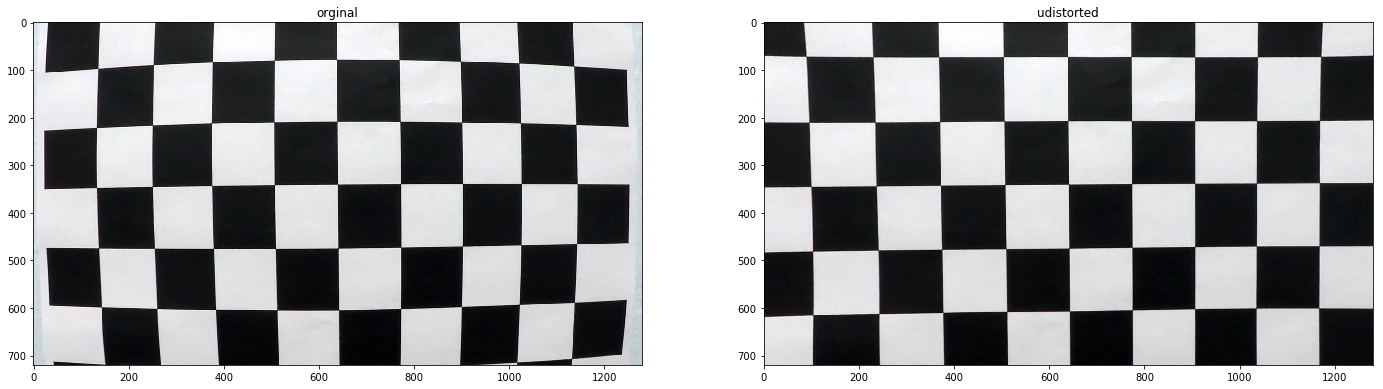

In [118]:
# Test distortion correction.
test_img = cv2.imread('camera_cal/calibration1.jpg')
undistorted = cv2.undistort(test_img,cameraMatrix,distCoeffs)

plot_many([test_img,undistorted],['orginal','udistorted'],[1,2])


In [37]:
def get_abs_sobel_mask(img, orient='x', kernel=3, thresh=(0,255)):
    
    grey  = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    if orient == 'x':
        abs_sobel = np.abs(cv2.Sobel(grey,cv2.CV_64F,1,0,None,kernel))
    elif orient == 'y':
        abs_sobel = np.abs(cv2.Sobel(grey,cv2.CV_64F,0,1,None,kernel))
    else:
        raise Exception("Invalid orientation {}".format(x))
     
    scaled_abs_sobel = (255. * abs_sobel / np.max(abs_sobel)).astype(np.uint8)
    
    binary_mask = np.logical_and(abs_sobel >= thresh[0], abs_sobel <= thresh[1] )
    
    return binary_mask.astype(np.uint8)

In [95]:
def get_mag_sobel_mask(img, kernel=3, mag_thresh=(0,255)):
    
    grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    abs_sobel_x = np.abs(cv2.Sobel(grey,cv2.CV_64F,1,0,None,kernel))
    abs_soble_y = np.abs(cv2.Sobel(grey,cv2.CV_64F,0,1,None,kernel))
    abs_sobel_mag = np.sqrt(abs_sobel_x**2+abs_soble_y**2)
    
    scaled_abs_sobel_mag = (abs_sobel_mag * 255.0 / np.max(abs_sobel_mag)).astype(np.uint8)
    
    binary_mask = np.logical_and(scaled_abs_sobel_mag >= mag_thresh[0], 
                                 scaled_abs_sobel_mag <= mag_thresh[1])
    
    return binary_mask.astype(np.uint8)

In [107]:
def get_ang_sobel_mask(img, kernel=3, ang_thresh=(0,np.pi/2.)):
    
    grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    abs_sobel_x = np.abs(cv2.Sobel(grey,cv2.CV_64F,1,0,None,kernel))
    abs_soble_y = np.abs(cv2.Sobel(grey,cv2.CV_64F,0,1,None,kernel))
    
    
    abs_sobel_angle = np.arctan2(abs_soble_y,abs_sobel_x)
    
    
    binary_mask = np.logical_and(abs_sobel_angle >= ang_thresh[0], 
                                 abs_sobel_angle <= ang_thresh[1])
    
    return binary_mask.astype(np.uint8)

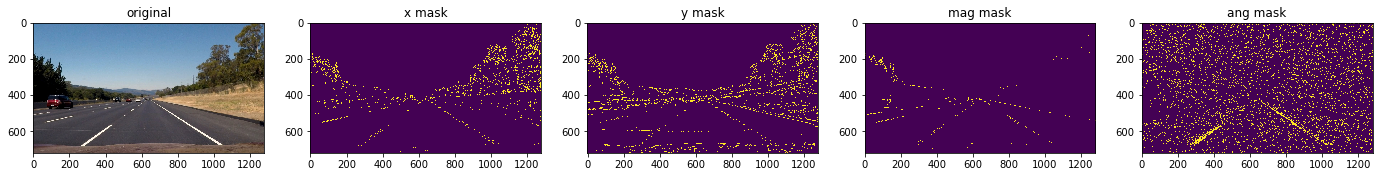

In [119]:
img = cv2.imread('test_images/straight_lines2.jpg')
rgb_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

mask1 = get_abs_sobel_mask(img,orient='x',kernel=3,thresh=(70,180))
mask2 = get_abs_sobel_mask(img,orient='y',kernel=3,thresh=(70,180))
mask3 = get_mag_sobel_mask(img,kernel=3,mag_thresh=(80,150))
mask4 = get_ang_sobel_mask(img,kernel=15,ang_thresh=(0.85,1.0))

plot_many([rgb_img,mask1,mask2,mask3,mask4],['original','x mask','y mask','mag mask','ang mask'],[1,5])